In [2]:
# from google.colab import drive
from pathlib import Path
# drive.mount('/content/gdrive', force_remount=True)
%cd "/content/drive/Othercomputers/my_mac/Coding_stuff/Projects/Surface_Predictor"

/content/drive/Othercomputers/my_mac/Coding_stuff/Projects/Surface_Predictor


In [3]:
creds = '{"username":"phade160","key":"e780a54d20d6c7d34b674893c923068a"}'
cred_path = Path('~/.kaggle/kaggle.json').expanduser()
if not cred_path.exists():
  print('entered')
cred_path.parent.mkdir(exist_ok=True)
cred_path.write_text(creds)
cred_path.chmod(0o600)

In [4]:
# !kaggle competitions download -c career-con-2019 -p ./data/
# !unzip ./data/X_test.csv.zip -d ./data
# !unzip ./data/X_train.csv.zip -d ./data
# !rm ./data/X_train.csv.zip ./data/X_test.csv.zip

In [6]:
%%capture
%pip install -Uqq pytorch-lightning torchmetrics wandb

In [7]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from matplotlib import rc
import seaborn as sns
import wandb
from tqdm.auto import tqdm 
from kaggle import api
import torch
import torch.autograd as autograd
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader
from torch.utils.data import WeightedRandomSampler

import pytorch_lightning as pl
from pytorch_lightning.callbacks import ModelCheckpoint, EarlyStopping
from pytorch_lightning.callbacks.progress import TQDMProgressBar
from pytorch_lightning.loggers import WandbLogger
import torchmetrics

from pylab import rcParams
from matplotlib.ticker import MaxNLocator
from sklearn.metrics import classification_report, confusion_matrix
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split

In [8]:
%matplotlib inline
%config InlinBackend.figure_format = 'retina'
sns.set_style(style= 'whitegrid')
rcParams['figure.figsize'] = 14,9

In [9]:
pl.seed_everything(42)

Global seed set to 42


42

In [10]:
!wandb login

wandb: Currently logged in as: phade160 (use `wandb login --relogin` to force relogin)


In [8]:
!pwd

/content/drive/Othercomputers/my_mac/Coding_stuff/Projects/Surface_Predictor


## Load Data

In [11]:
x_train = pd.read_csv('./data/raw/X_train.csv', low_memory=False)
y_train = pd.read_csv('./data/raw/y_train.csv', low_memory=False)
x_train

,row_id,series_id,measurement_number,orientation_X,orientation_Y,orientation_Z,orientation_W,angular_velocity_X,angular_velocity_Y,angular_velocity_Z,linear_acceleration_X,linear_acceleration_Y,linear_acceleration_Z
0,0_0,0,0,-0.75853,-0.63435,-0.104880,-0.105970,0.107650,0.017561,0.000767,-0.74857,2.1030,-9.7532
1,0_1,0,1,-0.75853,-0.63434,-0.104900,-0.106000,0.067851,0.029939,0.003386,0.33995,1.5064,-9.4128
2,0_2,0,2,-0.75853,-0.63435,-0.104920,-0.105970,0.007275,0.028934,-0.005978,-0.26429,1.5922,-8.7267
3,0_3,0,3,-0.75852,-0.63436,-0.104950,-0.105970,-0.013053,0.019448,-0.008974,0.42684,1.0993,-10.0960
4,0_4,0,4,-0.75852,-0.63435,-0.104950,-0.105960,0.005135,0.007652,0.005245,-0.50969,1.4689,-10.4410
...,...,...,...,...,...,...,...,...,...,...,...,...,...
487675,3809_123,3809,123,0.62871,-0.76878,-0.084391,0.081093,0.003167,0.093760,-0.142740,3.27180,2.0115,-9.0063
487676,3809_124,3809,124,0.62884,-0.76868,-0.084365,0.081099,0.014994,0.032637,-0.132380,4.42750,3.0696,-8.1257
487677,3809_125,3809,125,0.62891,-0.76861,-0.084345,0.081178,-0.031184,-0.003961,-0.138940,2.70480,4.2622,-8.1443
487678,3809_126,3809,126,0.62903,-0.76850,-0.084414,0.081231,-0.069153,0.013229,-0.130210,2.54100,4.7130,-9.4435


In [12]:
x_train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 487680 entries, 0 to 487679
Data columns (total 13 columns):
 #   Column                 Non-Null Count   Dtype  
---  ------                 --------------   -----  
 0   row_id                 487680 non-null  object 
 1   series_id              487680 non-null  int64  
 2   measurement_number     487680 non-null  int64  
 3   orientation_X          487680 non-null  float64
 4   orientation_Y          487680 non-null  float64
 5   orientation_Z          487680 non-null  float64
 6   orientation_W          487680 non-null  float64
 7   angular_velocity_X     487680 non-null  float64
 8   angular_velocity_Y     487680 non-null  float64
 9   angular_velocity_Z     487680 non-null  float64
 10  linear_acceleration_X  487680 non-null  float64
 11  linear_acceleration_Y  487680 non-null  float64
 12  linear_acceleration_Z  487680 non-null  float64
dtypes: float64(10), int64(2), object(1)
memory usage: 48.4+ MB


In [13]:
y_train

,series_id,group_id,surface
0,0,13,fine_concrete
1,1,31,concrete
2,2,20,concrete
3,3,31,concrete
4,4,22,soft_tiles
...,...,...,...
3805,3805,55,tiled
3806,3806,67,wood
3807,3807,48,fine_concrete
3808,3808,54,tiled


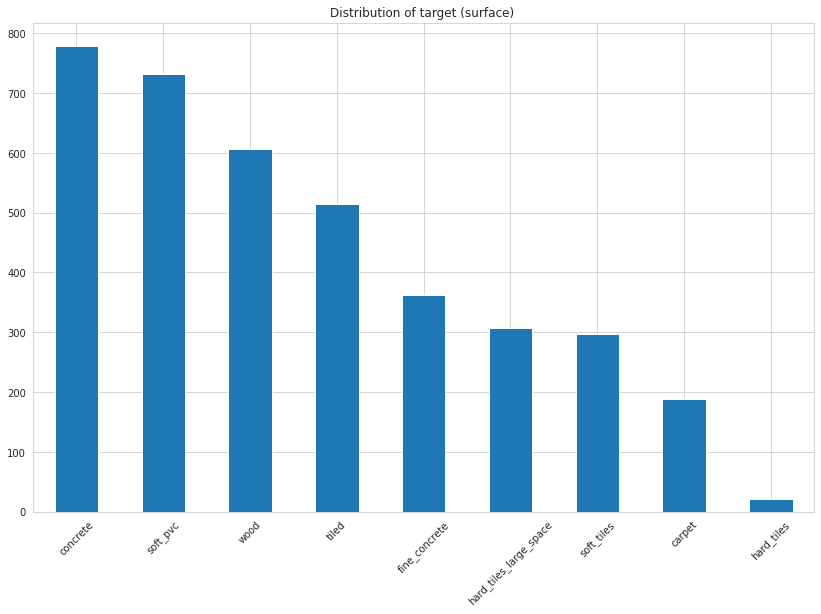

In [14]:
y_train.surface.value_counts().plot(kind='bar')
plt.xticks(rotation=45)
plt.title('Distribution of target (surface) ')
plt.show()

## Preprocessing

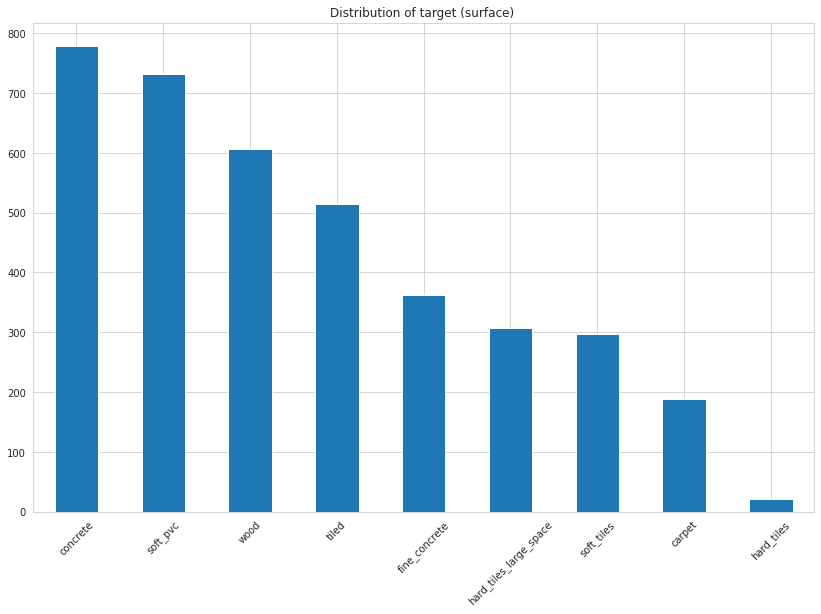

In [15]:
y_train.surface.value_counts().plot(kind='bar')
plt.xticks(rotation=45)
plt.title('Distribution of target (surface) ')
plt.show()

In [16]:
label_encoder =  LabelEncoder()
encoded_labels = label_encoder.fit_transform(y_train.surface)

In [17]:
label_encoder.classes_

array(['carpet', 'concrete', 'fine_concrete', 'hard_tiles',
       'hard_tiles_large_space', 'soft_pvc', 'soft_tiles', 'tiled',
       'wood'], dtype=object)

In [18]:
encoded_labels[:5], list(y_train.surface[:5])

(array([2, 1, 1, 1, 6]),
 ['fine_concrete', 'concrete', 'concrete', 'concrete', 'soft_tiles'])

In [19]:
y_train['label'] = encoded_labels
y_train

,series_id,group_id,surface,label
0,0,13,fine_concrete,2
1,1,31,concrete,1
2,2,20,concrete,1
3,3,31,concrete,1
4,4,22,soft_tiles,6
...,...,...,...,...
3805,3805,55,tiled,7
3806,3806,67,wood,8
3807,3807,48,fine_concrete,2
3808,3808,54,tiled,7


In [20]:
x_train

,row_id,series_id,measurement_number,orientation_X,orientation_Y,orientation_Z,orientation_W,angular_velocity_X,angular_velocity_Y,angular_velocity_Z,linear_acceleration_X,linear_acceleration_Y,linear_acceleration_Z
0,0_0,0,0,-0.75853,-0.63435,-0.104880,-0.105970,0.107650,0.017561,0.000767,-0.74857,2.1030,-9.7532
1,0_1,0,1,-0.75853,-0.63434,-0.104900,-0.106000,0.067851,0.029939,0.003386,0.33995,1.5064,-9.4128
2,0_2,0,2,-0.75853,-0.63435,-0.104920,-0.105970,0.007275,0.028934,-0.005978,-0.26429,1.5922,-8.7267
3,0_3,0,3,-0.75852,-0.63436,-0.104950,-0.105970,-0.013053,0.019448,-0.008974,0.42684,1.0993,-10.0960
4,0_4,0,4,-0.75852,-0.63435,-0.104950,-0.105960,0.005135,0.007652,0.005245,-0.50969,1.4689,-10.4410
...,...,...,...,...,...,...,...,...,...,...,...,...,...
487675,3809_123,3809,123,0.62871,-0.76878,-0.084391,0.081093,0.003167,0.093760,-0.142740,3.27180,2.0115,-9.0063
487676,3809_124,3809,124,0.62884,-0.76868,-0.084365,0.081099,0.014994,0.032637,-0.132380,4.42750,3.0696,-8.1257
487677,3809_125,3809,125,0.62891,-0.76861,-0.084345,0.081178,-0.031184,-0.003961,-0.138940,2.70480,4.2622,-8.1443
487678,3809_126,3809,126,0.62903,-0.76850,-0.084414,0.081231,-0.069153,0.013229,-0.130210,2.54100,4.7130,-9.4435


In [21]:
#we dont need the first 3 cols
feature_columns = x_train.columns.to_list()[3:]
feature_columns

['orientation_X',
 'orientation_Y',
 'orientation_Z',
 'orientation_W',
 'angular_velocity_X',
 'angular_velocity_Y',
 'angular_velocity_Z',
 'linear_acceleration_X',
 'linear_acceleration_Y',
 'linear_acceleration_Z']

## Build sequences

In [22]:
#it looks like the sequences have been grouped for us
x_train.series_id.value_counts()

0       128
2544    128
2532    128
2533    128
2534    128
       ... 
1274    128
1275    128
1276    128
1277    128
3809    128
Name: series_id, Length: 3810, dtype: int64

In [23]:
def get_sequences(df, test=False): 
  sequences = []
  for series_id, group in df.groupby('series_id'):
    sequence_features = group[feature_columns]
    if test:
      sequences.append(sequence_features)
    else:
      label = y_train[y_train.series_id == series_id].iloc[0].label
      sequences.append((sequence_features, label))
  return sequences

In [24]:
sequences = get_sequences(x_train)
sequences[0]

(     orientation_X  orientation_Y  ...  linear_acceleration_Y  linear_acceleration_Z
 0         -0.75853       -0.63435  ...                2.10300                -9.7532
 1         -0.75853       -0.63434  ...                1.50640                -9.4128
 2         -0.75853       -0.63435  ...                1.59220                -8.7267
 3         -0.75852       -0.63436  ...                1.09930               -10.0960
 4         -0.75852       -0.63435  ...                1.46890               -10.4410
 ..             ...            ...  ...                    ...                    ...
 123       -0.75943       -0.63316  ...                1.79890                -6.8687
 124       -0.75945       -0.63313  ...                2.35620                -6.8926
 125       -0.75949       -0.63309  ...                0.97328                -9.9795
 126       -0.75950       -0.63307  ...                0.34931               -11.9770
 127       -0.75953       -0.63306  ...               

In [25]:
from torch.utils.data import WeightedRandomSampler

In [26]:
train_sequences, val_sequences = train_test_split(sequences, test_size=0.2)
len(train_sequences), len(val_sequences)

(3048, 762)

In [27]:
#sanity check
len(train_sequences), len(val_sequences)
print('all train seq shape check: ',[(train_sequences[i][0].shape) for i in range(len(train_sequences)) if (train_sequences[i][0].shape) != (128, 10)])
# print('all train label shape check: ',[len(train_sequences[i][1]) for i in range(len(train_sequences)) if len(train_sequences[i][1]) != 10])
print('all train seq shape check: ',[(val_sequences[i][0].shape) for i in range(len(val_sequences)) if (val_sequences[i][0].shape) != (128, 10)])
# print('all train label shape check: ',[len(val_sequences[i][1]) for i in range(len(val_sequences)) if len(val_sequences[i][1]) != 10])

all train seq shape check:  []
all train seq shape check:  []


## Dataset and Datamodule

In [28]:

class SurfaceDataset(Dataset):

  def __init__(self, sequences, w_labels=True) -> None:
      super().__init__()
      self.sequences = sequences
      self.w_labels = w_labels

  def __len__(self):
    return len(self.sequences)

  def __getitem__(self, index):
    if not self.w_labels:
      sequence = self.sequences[index]
      return dict(
      sequence=torch.Tensor(sequence.to_numpy())
      )
      
    sequence, label = self.sequences[index]
    return dict(
      sequence=torch.Tensor(sequence.to_numpy()),
      label=torch.tensor(label).long()
    )



In [29]:
train_dataset = SurfaceDataset(train_sequences)
len(train_dataset)


3048

## Balancing the train data

In [30]:
lab_ids = [item['label'] for item in train_dataset]
labels_unique, counts = np.unique(lab_ids, return_counts=True)
labels_unique, counts

(array([0, 1, 2, 3, 4, 5, 6, 7, 8]),
 array([142, 607, 298,  16, 245, 591, 234, 425, 490]))

''

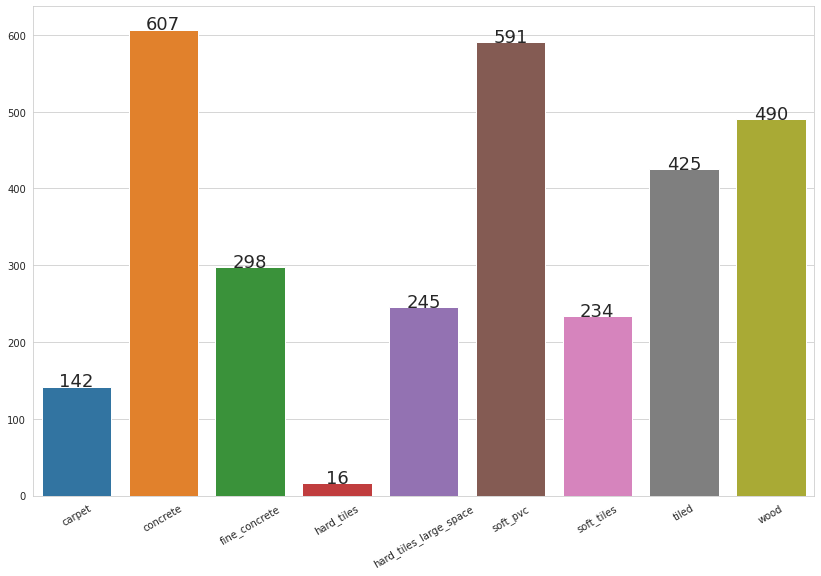

In [31]:
#lets plot them
# ax = sns.barplot(data=counts)
# ax.bar_label(ax.containers[0])
ax = sns.barplot(x=label_encoder.classes_,y=counts)

ax.set_xticklabels(ax.get_xticklabels(),rotation=30)
i=0
for p in ax.patches:
    height = p.get_height()
    ax.text(p.get_x()+p.get_width()/2., height + 0.1,
        counts[i],ha="center", size=18)
    i += 1
;

In [32]:
class_weights = [sum(counts)/c for c in counts]
class_weights

[21.464788732394368,
 5.021416803953872,
 10.228187919463087,
 190.5,
 12.440816326530612,
 5.157360406091371,
 13.025641025641026,
 7.171764705882353,
 6.220408163265306]

In [33]:
sample_weights = [class_weights[e] for e in lab_ids ]
sample_weights

[12.440816326530612,
 12.440816326530612,
 5.157360406091371,
 12.440816326530612,
 5.157360406091371,
 12.440816326530612,
 5.021416803953872,
 13.025641025641026,
 7.171764705882353,
 12.440816326530612,
 5.157360406091371,
 10.228187919463087,
 5.157360406091371,
 5.157360406091371,
 5.157360406091371,
 7.171764705882353,
 12.440816326530612,
 6.220408163265306,
 5.157360406091371,
 21.464788732394368,
 13.025641025641026,
 10.228187919463087,
 5.021416803953872,
 7.171764705882353,
 10.228187919463087,
 7.171764705882353,
 5.021416803953872,
 5.157360406091371,
 12.440816326530612,
 6.220408163265306,
 5.021416803953872,
 13.025641025641026,
 5.021416803953872,
 5.021416803953872,
 5.157360406091371,
 13.025641025641026,
 7.171764705882353,
 10.228187919463087,
 13.025641025641026,
 5.021416803953872,
 12.440816326530612,
 6.220408163265306,
 6.220408163265306,
 12.440816326530612,
 10.228187919463087,
 7.171764705882353,
 6.220408163265306,
 21.464788732394368,
 7.171764705882353,

In [34]:
sampler = WeightedRandomSampler(sample_weights,  num_samples=len(sample_weights), replacement=True)
sampler

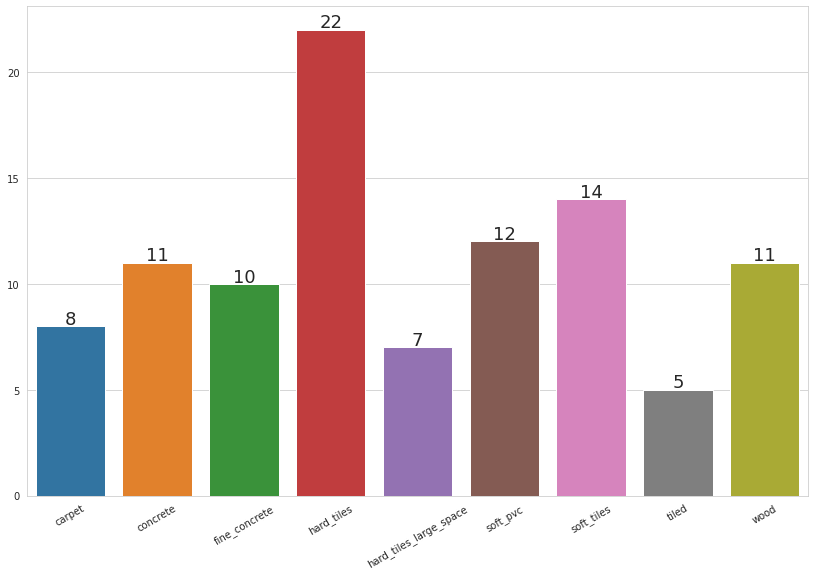

In [35]:
# lets check what this will yield when loading the dataset with a DataLoader

train_dl = DataLoader(train_dataset, sampler=sampler, batch_size=100)
# see one batch
for idx, batch in enumerate(train_dl):
    x,y = batch['sequence'], batch['label']
    _, c = np.unique(y, return_counts=True)
    ax = sns.barplot(x=label_encoder.classes_,y=c)

    ax.set_xticklabels(ax.get_xticklabels(),rotation=30)
    i=0
    for p in ax.patches:
        height = p.get_height()
        ax.text(p.get_x()+p.get_width()/2., height + 0.1,
            c[i],ha="center", size=18)
        i += 1
    break



In [36]:
# see all train data
batches = []
for idx, batch in enumerate(train_dl):
    x,y = batch['sequence'], batch['label']
    batches.append(y.numpy())

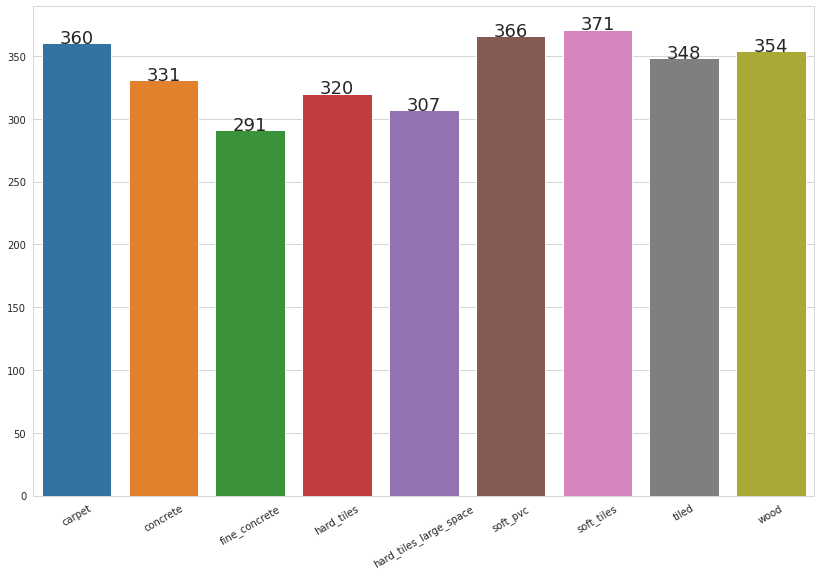

In [37]:
_, c = np.unique(np.concatenate(batches), return_counts=True)
ax = sns.barplot(x=label_encoder.classes_,y=c)

ax.set_xticklabels(ax.get_xticklabels(),rotation=30)
i=0
for p in ax.patches:
    height = p.get_height()
    ax.text(p.get_x()+p.get_width()/2., height + 0.1,
        c[i],ha="center", size=18)
    i += 1

In [38]:
#lets put it in a function for our lit data madule
def get_sampler(dataset):
    lab_ids = [d['label'] for d in dataset]
    labels_unique, counts = np.unique(lab_ids, return_counts=True)
    class_weights = [sum(counts)/c for c in counts]
    sample_weights = [class_weights[e] for e in lab_ids ]
    sampler = WeightedRandomSampler(sample_weights,  num_samples=len(sample_weights), replacement=True)
    return sampler

In [39]:
class SurfaceDatamodule(pl.LightningDataModule):

  def __init__(self, train_sequences, val_sequences, batch_size, balance=True):
    super().__init__()
    self.train_sequences = train_sequences
    self.val_sequences = val_sequences
    self.batch_size = batch_size
    self.balance = balance
    self.sampler = None

  def setup(self, stage=None):
    self.train_dataset = SurfaceDataset(self.train_sequences)
    self.val_dataset = SurfaceDataset(self.val_sequences)
    if self.balance:
      self.sampler = get_sampler(self.train_dataset)

  def train_dataloader(self):
    if self.balance:
        return DataLoader(self.train_dataset, 
                          batch_size=self.batch_size,
                          sampler=self.sampler,
                          num_workers=3)
    return DataLoader(self.train_dataset, 
                  batch_size=self.batch_size,
                  num_workers=3)
      
  def val_dataloader(self):
      return DataLoader(self.val_dataset,
                        batch_size=self.batch_size,
                        num_workers=2)


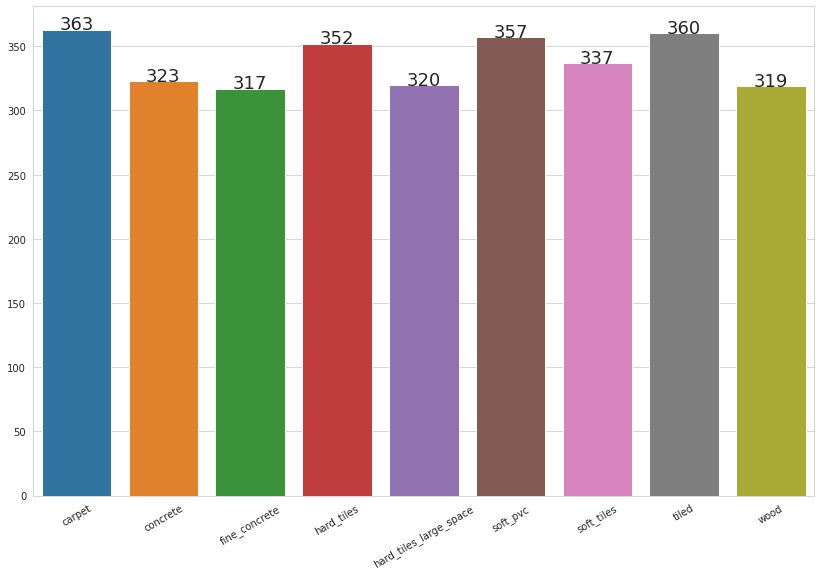

In [40]:
dm =SurfaceDatamodule(train_sequences, val_sequences, batch_size=100)
dm.setup()

# dm.train_dataloader().dataset
batches = []
for idx, batch in enumerate(dm.train_dataloader()):
    x,y = batch['sequence'], batch['label']
    batches.append(y.numpy())

_, c = np.unique(np.concatenate(batches), return_counts=True)
ax = sns.barplot(x=label_encoder.classes_,y=c)

ax.set_xticklabels(ax.get_xticklabels(),rotation=30)
i=0
for p in ax.patches:
    height = p.get_height()
    ax.text(p.get_x()+p.get_width()/2., height + 0.1,
        c[i],ha="center", size=18)
    i += 1

## Architecture and PL Module

In [41]:

class SurfaceModel(nn.Module):

  def __init__(self, n_features, n_classes, n_hidden,dropout, n_layers=3):
    super().__init__()
    print(dropout)
    self.n_fearues = n_features
    self.n_classes = n_classes
    self.n_hidden = n_hidden
    self.n_layers = n_layers
    self.dropout = dropout

    self.lstm = nn.LSTM(
        input_size =self.n_fearues,
        hidden_size = self.n_hidden,
        num_layers = self.n_layers,
        dropout = self.dropout,
        batch_first = True
    )
    self.cassifier = nn.Linear(self.n_hidden, self.n_classes)

  def forward(self, x):
        self.lstm.flatten_parameters()
        _, (hidden,_) = self.lstm(x)
        out = hidden[-1]
        return self.cassifier(out)

In [44]:
class SurfacePredictor(pl.LightningModule):
  def __init__(self, n_features, n_classes, n_hidden, seq_length, dropout, n_layers=3, lr=0.0001):
    super().__init__()
    self.lr = lr 
    self.seq_length =seq_length
    self.n_features = n_features

    self.model = SurfaceModel(n_features, n_classes, n_hidden, n_layers=n_layers,dropout=dropout)
    self.criterion = nn.CrossEntropyLoss()
    self.train_ac = torchmetrics.Accuracy()
    self.val_ac = torchmetrics.Accuracy()
    self.save_hyperparameters()


  def forward(self, x, labels=None):
    output = self.model(x)

    loss = 0
    if labels is not None:
      loss = self.criterion(output, labels)
      return loss, output

    return output


  def training_step(self, batch, batch_idx):
    sequences = batch['sequence']
    labels = batch['label']
    loss, outputs = self(sequences, labels)
    predictions = torch.argmax(outputs, dim=1)
    step_ac = self.train_ac(predictions, labels)

    self.log('train_loss', loss, prog_bar=True, logger=True)
    self.log('train_accuracy', step_ac, prog_bar=True, logger=True)

    return dict(loss=loss, accuracy=step_ac)

  def validation_step(self, batch, batch_idx):
    sequences = batch['sequence']
    labels = batch['label']
    loss, outputs = self(sequences, labels)
    predictions = torch.argmax(outputs, dim=1)
    step_ac = self.train_ac(predictions, labels)

    self.log('val_loss', loss, prog_bar=True, logger=True)
    self.log('val_accuracy', step_ac, prog_bar=True, logger=True)

    return dict(loss=loss, accuracy=step_ac, loggits=outputs)


  def validation_epoch_end(self, validation_step_outputs):
    dummyImput = torch.zeros(
        (1, self.seq_length, self.n_features), device=self.device)
    model_filename = f"model_{str(self.global_step).zfill(5)}.onnx"
    # torch.onnx.export(self, dummyImput, model_filename, opset_version=11)
    # wandb.save(model_filename,)
    outputs = [out['loggits'] for out in validation_step_outputs]
    flattened_outputs = torch.flatten(
          torch.cat(outputs))
    self.logger.experiment.log(
    {'valid/logits': wandb.Histogram(flattened_outputs.to('cpu')),
      'epoch': self.current_epoch}
    )


  def configure_optimizers(self):
    return torch.optim.AdamW(self.parameters(), lr=self.lr)
 

## Hyperparameter Tuning

In [43]:
rand_sweep_config = {
  "method": "random",   # Random search
  "metric": {           # We want to maximize val_accuracy
      "name": "val_accuracy",
      "goal": "maximize"
  },
  "parameters": {
        "dropout": {
            # Choose from pre-defined values
            "values": [0.3, 0.4, 0.5, 0.75, 0.85]
        },
        "n_hidden": {
            # Choose from pre-defined values
            "values": [64, 128, 256, 512]
        },
        "batch_size": {
            # Choose from pre-defined values
            "values": [64, 128, 256, 512]
        },
        "lr": {
            # log uniform distribution between exp(min) and exp(max)
            "values": [0.1, 0.01, 0.004, 0.001, 0.0004, 0.0001] 
        }
    }
}

In [45]:
def sweep_iteration():

    # set up W&B logger
    wandb.init(config=rand_sweep_config)    # required to have access to `wandb.config`
    config = wandb.config

    # setup data
    data_module =SurfaceDatamodule(train_sequences, val_sequences, batch_size=config.batch_size)

    # setup model - note how we refer to sweep parameters with wandb.config
    model = SurfacePredictor(n_features= 10,n_classes= 9,
                           n_hidden= config.n_hidden,
                           seq_length= 128, 
                           dropout = config.dropout, lr = config.lr)

    # early_stopping_callback = EarlyStopping(monitor='val_loss', patience=4, verbose=True)
    progress_bar = TQDMProgressBar(refresh_rate=30)

    logger = WandbLogger(name='rand-sweep', save_dir='./logs', project='surface_pred_sweep', log_model=True)
    callbacks = [progress_bar]

    # setup Trainer
    trainer = pl.Trainer(gpus = 1,
                        max_epochs = 50,
                        logger= logger,
                        callbacks = callbacks,
                        precision=16)

    # train
    trainer.fit(model, datamodule=data_module)
    wandb.finish()

In [ ]:
sweep_id = wandb.sweep(rand_sweep_config, project="Surface_predict-rand")
wandb.agent(sweep_id, sweep_iteration, count=100)
wandb.finish()

In [72]:
def train(data_module, params, run_name):
    # setup data
    #setup model
    model = SurfacePredictor(n_features= params['n_features'], 
                             n_classes= params['n_classes'],
                             n_hidden= params['n_hidden'], 
                             seq_length = params['seq_length'],
                             dropout = params['dropout'], 
                             lr = params['lr'],
                             n_layers= params['n_layers'])
    # set up W&B logger
    checkpoint_callback = ModelCheckpoint(
    dirpath='checkpoints',
    filename='best_checkpoint',
    save_top_k=1,
    verbose=True,
    monitor='val_accuracy',
    mode='max'
    )
    early_stopping_callback = EarlyStopping(monitor='val_accuracy', patience=10, verbose=True)
    progress_bar = TQDMProgressBar(refresh_rate=30)

    callbacks = [early_stopping_callback, checkpoint_callback, progress_bar]
    
    logger = WandbLogger(name=run_name, save_dir='logs', project='surface_pred')
    progress_bar = TQDMProgressBar(refresh_rate=30,)

    callbacks = [progress_bar]

    # setup Trainer
    trainer = pl.Trainer(gpus = 1,
                        max_epochs = 250,
                        logger= logger,
                        callbacks = callbacks,
                        log_every_n_steps=40,
                        precision=16)

    # train
    trainer.fit(model, datamodule=data_module)
    wandb.finish()
    return trainer, data_module

In [75]:
params ={
    'n_features': len(feature_columns),
    "n_classes": len(label_encoder.classes_),
    "seq_length":128,
    "dropout": 0.3,
    "n_hidden": 256,
    "batch_size": 64,
    "lr": 0.001,
    "n_layers" : 3   
    }
data_module =SurfaceDatamodule(train_sequences, val_sequences, batch_size=params['batch_size'])
trainer, data_module = train(data_module, params, 'run-5')

Using 16bit native Automatic Mixed Precision (AMP)
GPU available: True, used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


0.3
Problem at: /usr/local/lib/python3.7/dist-packages/pytorch_lightning/loggers/wandb.py 339 experiment


/usr/local/lib/python3.7/dist-packages/pytorch_lightning/trainer/trainer.py:688: UserWarning: Detected KeyboardInterrupt, attempting graceful shutdown...
  rank_zero_warn("Detected KeyboardInterrupt, attempting graceful shutdown...")


### Predictions

In [51]:
trainer.checkpoint_callback.best_model_path

'logs/surface_pred/vmcojylp/checkpoints/epoch=249-step=11999.ckpt'

In [52]:
trained_model = SurfacePredictor.load_from_checkpoint(trainer.checkpoint_callback.best_model_path)
trained_model.freeze()

0.3


0.75


In [53]:
val_dataset = SurfaceDataset(val_sequences)
def predict(dataset, model, w_labels=True):    

    predictions = []
    labels = []

    trained_model.eval()
    with torch.no_grad():
        for item in tqdm(dataset, desc='iterations'):
            sequence = item['sequence']
            output = model(sequence.unsqueeze(0))
            pred = torch.argmax(output, dim=1)
            predictions.append(pred.item())
            if w_labels:
                label = item['label']
                labels.append(label.item())

    return predictions, labels


In [54]:
predictions, labels =  predict(val_dataset, trained_model, w_labels=True)

iterations:   0%|          | 0/762 [00:00<?, ?it/s]

In [57]:
classes = label_encoder.classes_

In [59]:
def show_confusion_matrix(cm):
    hmap = sns.heatmap(cm, annot=True, fmt='d', cmap='Blues' )
    hmap.yaxis.set_ticklabels(hmap.yaxis.get_ticklabels(), rotation=0, ha='right')
    hmap.xaxis.set_ticklabels(hmap.xaxis.get_ticklabels(), rotation=30, ha='right')
    plt.ylabel('True Surface')
    plt.xlabel('Predicted Surface')

In [60]:
def get_report(labels, predictions,classes ):
    print(classification_report(labels, predictions, target_names=classes))
    cm = confusion_matrix(labels, predictions)
    cm_df = pd.DataFrame(cm, index=classes, columns=classes)
    show_confusion_matrix(cm_df)

                        precision    recall  f1-score   support

                carpet       0.77      0.70      0.73        47
              concrete       0.80      0.83      0.81       172
         fine_concrete       0.63      0.49      0.55        65
            hard_tiles       0.00      0.00      0.00         5
hard_tiles_large_space       0.85      0.81      0.83        63
              soft_pvc       0.82      0.87      0.85       141
            soft_tiles       0.92      0.92      0.92        63
                 tiled       0.70      0.73      0.71        89
                  wood       0.68      0.72      0.70       117

              accuracy                           0.77       762
             macro avg       0.69      0.67      0.68       762
          weighted avg       0.77      0.77      0.77       762



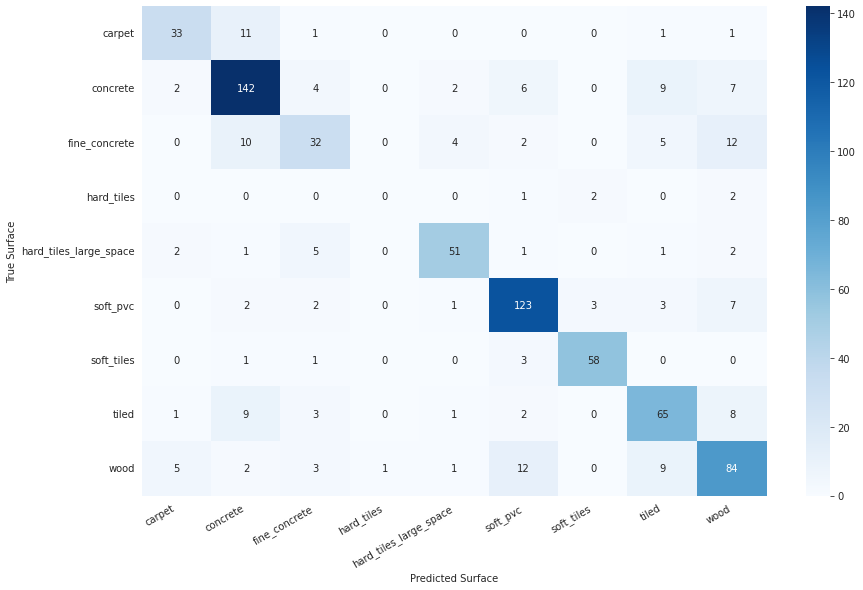

In [61]:
get_report(labels, predictions, classes )

### Test Predictions 

In [62]:
#load data
x_test = pd.read_csv('./data/raw/X_test.csv', low_memory=False)
x_test


,row_id,series_id,measurement_number,orientation_X,orientation_Y,orientation_Z,orientation_W,angular_velocity_X,angular_velocity_Y,angular_velocity_Z,linear_acceleration_X,linear_acceleration_Y,linear_acceleration_Z
0,0_0,0,0,0.91208,-0.38193,-0.050618,0.14028,-0.060205,0.071286,-0.187870,0.29492,2.8027,-9.6816
1,0_1,0,1,0.91220,-0.38165,-0.050573,0.14028,-0.033486,0.060210,-0.182060,0.14944,2.5408,-9.8521
2,0_2,0,2,0.91228,-0.38143,-0.050586,0.14032,-0.029686,0.029476,-0.184410,-0.49741,2.5853,-9.3835
3,0_3,0,3,0.91237,-0.38121,-0.050588,0.14035,-0.024217,0.037788,-0.187830,-0.32376,2.9966,-8.7415
4,0_4,0,4,0.91247,-0.38096,-0.050546,0.14042,-0.038047,0.083405,-0.201700,-0.70103,2.6498,-8.8432
...,...,...,...,...,...,...,...,...,...,...,...,...,...
488443,3815_123,3815,123,0.89516,-0.42026,-0.056425,0.13744,0.036579,0.008990,-0.008570,0.76537,3.5421,-8.4445
488444,3815_124,3815,124,0.89517,-0.42025,-0.056391,0.13742,0.022401,0.021198,-0.010905,-0.48107,3.3380,-8.8012
488445,3815_125,3815,125,0.89521,-0.42019,-0.056343,0.13734,0.033571,0.019868,-0.007203,0.44106,3.2110,-9.3700
488446,3815_126,3815,126,0.89522,-0.42019,-0.056300,0.13730,0.046988,0.015570,0.001514,-0.25947,2.8634,-9.8546


In [63]:
test_sequences = get_sequences(x_test, test=True)
test_sequences[0]

,orientation_X,orientation_Y,orientation_Z,orientation_W,angular_velocity_X,angular_velocity_Y,angular_velocity_Z,linear_acceleration_X,linear_acceleration_Y,linear_acceleration_Z
0,0.91208,-0.38193,-0.050618,0.14028,-0.060205,0.071286,-0.18787,0.29492,2.8027,-9.6816
1,0.91220,-0.38165,-0.050573,0.14028,-0.033486,0.060210,-0.18206,0.14944,2.5408,-9.8521
2,0.91228,-0.38143,-0.050586,0.14032,-0.029686,0.029476,-0.18441,-0.49741,2.5853,-9.3835
3,0.91237,-0.38121,-0.050588,0.14035,-0.024217,0.037788,-0.18783,-0.32376,2.9966,-8.7415
4,0.91247,-0.38096,-0.050546,0.14042,-0.038047,0.083405,-0.20170,-0.70103,2.6498,-8.8432
...,...,...,...,...,...,...,...,...,...,...
123,0.92745,-0.34256,-0.044737,0.14314,-0.042345,0.110970,-0.28062,-1.61520,3.9206,-9.7290
124,0.92757,-0.34221,-0.044644,0.14323,-0.037892,0.137240,-0.27835,0.14804,4.4519,-9.1428
125,0.92772,-0.34179,-0.044559,0.14332,-0.022882,0.140620,-0.27047,-1.20300,3.7139,-8.6641
126,0.92784,-0.34143,-0.044497,0.14338,-0.024329,0.106640,-0.28700,-0.30051,4.0866,-8.6810


In [64]:
test_dataset = SurfaceDataset(test_sequences, w_labels=False)
len(test_dataset)

3816

In [66]:
predictions, _ = predict(test_dataset, trained_model, w_labels=False)

iterations:   0%|          | 0/3816 [00:00<?, ?it/s]

In [67]:
len(predictions)

3816

In [68]:
series_ids= x_test.series_id.unique()
len(series_ids), series_ids

(3816, array([   0,    1,    2, ..., 3813, 3814, 3815]))

In [69]:
surfaces = [label_encoder.classes_[i] for i in predictions]

In [70]:
sub = pd.DataFrame({'series_id':series_ids ,'surface': surfaces})
sub.to_csv('03_submission.csv', index=False)
sub

,series_id,surface
0,0,soft_tiles
1,1,wood
2,2,fine_concrete
3,3,wood
4,4,concrete
...,...,...
3811,3811,concrete
3812,3812,tiled
3813,3813,carpet
3814,3814,soft_tiles


In [71]:
api.competition_submit_cli('03_submission.csv', 'after hyperparameter tuning', 'career-con-2019')

100%|██████████| 52.4k/52.4k [00:01<00:00, 39.0kB/s]


Successfully submitted to CareerCon 2019 - Help Navigate Robots 

### Train with all data

In [76]:
data_module =SurfaceDatamodule(sequences, val_sequences, batch_size=params['batch_size'])
trainer, data_module = train(data_module, params, 'run_5-all_data')

Using 16bit native Automatic Mixed Precision (AMP)
GPU available: True, used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


0.3



  | Name      | Type             | Params
-----------------------------------------------
0 | model     | SurfaceModel     | 1.3 M 
1 | criterion | CrossEntropyLoss | 0     
2 | train_ac  | Accuracy         | 0     
3 | val_ac    | Accuracy         | 0     
-----------------------------------------------
1.3 M     Trainable params
0         Non-trainable params
1.3 M     Total params
2.659     Total estimated model params size (MB)


Validation sanity check: 0it [00:00, ?it/s]

/usr/local/lib/python3.7/dist-packages/pytorch_lightning/trainer/data_loading.py:133: UserWarning: The dataloader, val_dataloader 0, does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` (try 4 which is the number of cpus on this machine) in the `DataLoader` init to improve performance.
  f"The dataloader, {name}, does not have many workers which may be a bottleneck."
Global seed set to 42


Training: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

epoch,▁▁▁▂▂▂▂▂▂▃▃▃▃▃▃▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▇▇▇▇▇▇███
train_accuracy,▂▂▁▂▃▃▄▄▄▅▅▆▆▇▆▆▆▇▇▇▇▇████▇▇▇█████▇█████
train_loss,▇██▇▆▆▆▅▅▄▄▃▃▂▃▃▂▁▂▂▁▂▁▁▁▁▂▂▂▁▁▁▁▁▂▁▁▁▁▁
trainer/global_step,▁▁▁▂▂▂▂▂▂▃▃▃▃▃▃▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▇▇▇▇▇▇███
val_accuracy,▂▂▂▁▃▃▃▃▄▄▅▆▆▆▇▇▇▇▇▇▇▇▇█████████████████
val_loss,▇█▇█▇▆▆▆▅▅▄▄▃▃▃▂▂▂▂▂▂▂▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
epoch,249
train_accuracy,0.97059
train_loss,0.07836
trainer/global_step,14999
val_accuracy,0.98294


In [77]:
trainer.checkpoint_callback.best_model_path

'logs/surface_pred/1ezf2avg/checkpoints/epoch=249-step=14999.ckpt'

In [78]:
trained_model = SurfacePredictor.load_from_checkpoint(trainer.checkpoint_callback.best_model_path)
trained_model.freeze()

0.3


In [79]:
val_dataset = SurfaceDataset(val_sequences)
predictions, labels =  predict(val_dataset, trained_model, w_labels=True)

iterations:   0%|          | 0/762 [00:00<?, ?it/s]

                        precision    recall  f1-score   support

                carpet       0.96      1.00      0.98        47
              concrete       0.99      0.97      0.98       172
         fine_concrete       0.96      1.00      0.98        65
            hard_tiles       1.00      1.00      1.00         5
hard_tiles_large_space       1.00      1.00      1.00        63
              soft_pvc       0.98      0.98      0.98       141
            soft_tiles       0.98      1.00      0.99        63
                 tiled       1.00      0.97      0.98        89
                  wood       0.98      0.98      0.98       117

              accuracy                           0.98       762
             macro avg       0.98      0.99      0.99       762
          weighted avg       0.98      0.98      0.98       762



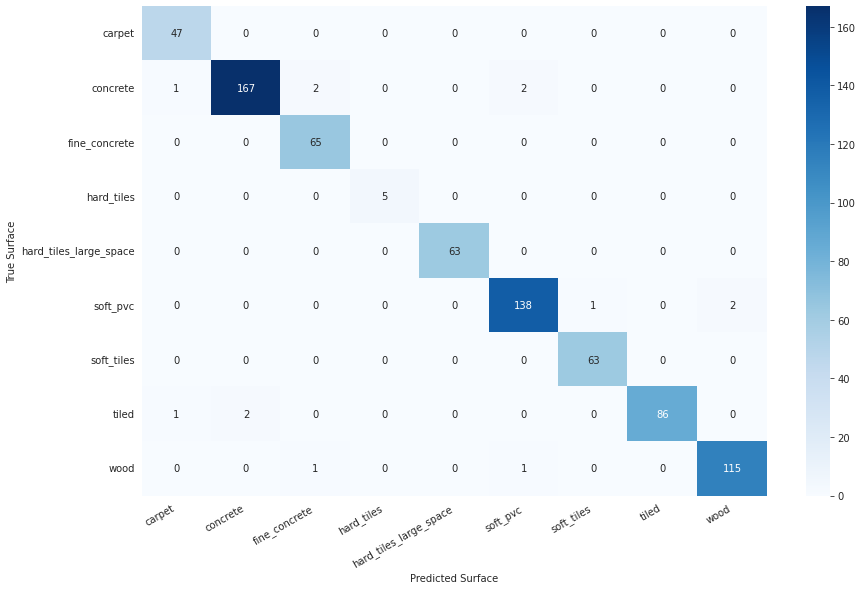

In [80]:
get_report(labels, predictions, classes)

### On Test set

In [81]:
predictions, _ = predict(test_dataset, trained_model, w_labels=False)

iterations:   0%|          | 0/3816 [00:00<?, ?it/s]

In [82]:
surfaces = [label_encoder.classes_[i] for i in predictions]
sub = pd.DataFrame({'series_id':series_ids ,'surface': surfaces})
sub.to_csv('output/03_submission.csv', index=False)
sub

,series_id,surface
0,0,soft_pvc
1,1,wood
2,2,concrete
3,3,wood
4,4,fine_concrete
...,...,...
3811,3811,concrete
3812,3812,tiled
3813,3813,soft_pvc
3814,3814,soft_tiles


In [83]:
api.competition_submit_cli('output/03_submission.csv', 'after hyperparameter tuning', 'career-con-2019')

100%|██████████| 53.1k/53.1k [00:01<00:00, 31.8kB/s]


Successfully submitted to CareerCon 2019 - Help Navigate Robots 